## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the raws with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import pandas as pd
import numpy as np

In [3]:
#es 1
file_name="../data/data_000637.txt"
data=pd.read_csv(file_name)
n_r=data.shape[0]
N=np.random.randint(10000,n_r)
data2=pd.read_csv(file_name, nrows=N)
data2

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,1,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


In [4]:
print(N)

792166


In [5]:
#es2 
x=data['BX_COUNTER'].max()+1
print(x)

3564


In [4]:
data.describe()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
count,1310720.0,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06
mean,1.0,2.959198e-01,5.582570e+01,3.869206e+09,1.781096e+03,1.332340e+01
std,0.0,4.564553e-01,3.901034e+01,3.183124e+03,1.027795e+03,9.199886e+00
min,1.0,0.000000e+00,1.000000e+00,3.869200e+09,0.000000e+00,0.000000e+00
25%,1.0,0.000000e+00,2.600000e+01,3.869203e+09,8.930000e+02,5.000000e+00
50%,1.0,0.000000e+00,5.700000e+01,3.869207e+09,1.778000e+03,1.300000e+01
75%,1.0,1.000000e+00,6.400000e+01,3.869209e+09,2.670000e+03,2.100000e+01
max,1.0,1.000000e+00,1.390000e+02,3.869211e+09,3.563000e+03,2.900000e+01


In [6]:
#es 3
max_orbit=data['ORBIT_CNT'].max()
y=data['ORBIT_CNT'].max()- data['ORBIT_CNT'].min()
print(y)
data3=data[data['ORBIT_CNT']==max_orbit]
max_bx=data3['BX_COUNTER'].max()
print(max_bx)
data4=data3[data3['BX_COUNTER']==max_bx]
data4


11004
769


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
1310718,1,0,139,3869211171,769,0


In [7]:
print('data taking last:',max_orbit*25*x + max_bx*25,'ns')

data taking last: 344746715355325 ns


In [8]:
#es 4
data['timens']=data['TDC_MEAS']*25/30+data['BX_COUNTER']*25+data['ORBIT_CNT']*25*x
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
7,1,0,139,3869200167,2776,0,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
9,1,0,60,3869200167,2788,7,3.447457e+14


In [9]:
#es 5
data['HEAD']=np.random.randint(0,2,n_r)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
0,1,0,123,3869200167,2374,26,3.447457e+14
1,0,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,0,0,64,3869200167,2558,19,3.447457e+14
4,0,0,64,3869200167,2760,25,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,0,0,61,3869200167,2772,14,3.447457e+14
7,1,0,139,3869200167,2776,0,3.447457e+14
8,0,0,62,3869200167,2774,21,3.447457e+14
9,0,0,60,3869200167,2788,7,3.447457e+14


In [10]:
#es 6 
data5= data[data['HEAD']==1]
data5

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
0,1,0,123,3869200167,2374,26,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
7,1,0,139,3869200167,2776,0,3.447457e+14
10,1,1,7,3869200167,2785,4,3.447457e+14
12,1,1,6,3869200167,2792,18,3.447457e+14
13,1,0,36,3869200167,2791,23,3.447457e+14
18,1,1,5,3869200167,2795,4,3.447457e+14
21,1,0,57,3869200167,2789,10,3.447457e+14
26,1,0,59,3869200167,2799,14,3.447457e+14


In [11]:
data5.shape[0]

655195

C:\Users\saret\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


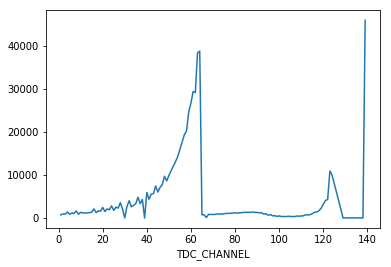

In [13]:
#es 7
data6=data2[data['FPGA']==0]
data7=data6.groupby('TDC_CHANNEL').sum()
plot1=pd.Series(data7['HEAD'], index=data7.index)
plot1.plot()



In [22]:
#data6

In [23]:
#data7

C:\Users\saret\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


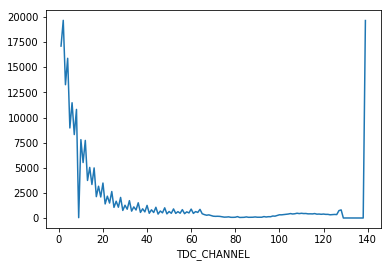

In [14]:
#es 7 bis
data8=data2[data['FPGA']==1]
data9=data8.groupby('TDC_CHANNEL').sum()
plot2=pd.Series(data9['HEAD'], index=data9.index)
plot2.plot()


In [15]:
#es 8
data7.sort_values('HEAD')

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS
TDC_CHANNEL,,,,,
39,1,0,3869204964,2005,2
129,2,0,7738405323,3452,28
30,3,0,11607613023,5064,22
137,19,0,73514890046,31093,149
130,20,0,77384082842,25875,285
138,20,0,77384094541,32182,152
67,102,0,394658823204,165790,1509
103,317,0,1226537740116,541118,4770
106,332,0,1284575753525,593395,4724


In [26]:
#es 8 bis
data9.sort_values('HEAD')

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS
TDC_CHANNEL,,,,,
129,11,11,42561228000,14548,197
137,12,12,46430431462,15317,168
138,12,12,46430431462,15317,60
130,14,14,54168834322,31277,183
9,40,40,154768111293,72912,559
83,56,56,216675364267,99227,966
84,60,60,232152172575,119353,947
79,62,62,239890564208,107342,1004
82,62,62,239890572268,109998,767


In [16]:
print('Most noisy channels (FPGA,CHANNEL): (0,139),(0,64),(0,63)',)

Most noisy channels (FPGA,CHANNEL): (0,139),(0,64),(0,63)


In [18]:
#es 9
data2.groupby('ORBIT_CNT').size()
unique_orbit=data2.groupby('ORBIT_CNT').size()
unique_orbit=unique_orbit[unique_orbit==1]
print('ORBIT_CNT that appears only once:')
unique_orbit

ORBIT_CNT that appears only once:


ORBIT_CNT
3869204142    1
3869206180    1
dtype: int64

In [19]:
#data2.groupby('ORBIT_CNT').size()
print('Number of distinct ORBIT_CNT:')
data2['ORBIT_CNT'].unique().shape[0]

Number of distinct ORBIT_CNT:


7453

In [57]:
data139=data2[data2['TDC_CHANNEL']==139]
unique_orbit139=data139.groupby('ORBIT_CNT').size()
unique_orbit139=unique_orbit139[unique_orbit139==1]
#unique_orbit139
print('Number of ORBIT_CNT that appear only once when TDC_CHANNEL=139:')
unique_orbit139.shape[0]


Number of ORBIT_CNT that appear only once when TDC_CHANNEL=139:


51

In [58]:
#unique_orbit139

In [59]:
data139=data2[data2['TDC_CHANNEL']==139]
data139
print('Number of distinct ORBIT_CNT when TDC_CHANNEL=139:')
data139['ORBIT_CNT'].unique().shape[0]

Number of distinct ORBIT_CNT when TDC_CHANNEL=139:


7085